# EDA for MetMCC-SCAN

### Yanrong (Jerry) Ji

In [1]:
%matplotlib inline

In [53]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.feature_selection import VarianceThreshold

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [4]:
BASE_DIR = os.path.dirname(os.path.realpath('EDA')) + '/'

In [20]:
# read in data
mcc_ncdb = pd.read_csv(BASE_DIR + '../data/Merkel.csv')
mcc_seer = pd.read_csv(BASE_DIR + '../data/MerkelCasesSEER.csv')

In [22]:
mcc_ncdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Columns: 126 entries, PUF_CASE_ID to PALLIATIVE_CARE_HOSP
dtypes: float64(59), int64(56), object(11)
memory usage: 33.5+ MB


In [24]:
mcc_seer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9280 entries, 0 to 9279
Data columns (total 37 columns):
 #   Column                                                             Non-Null Count  Dtype
---  ------                                                             --------------  -----
 0   Age recode with <1 year olds                                       9280 non-null   int64
 1   Sex                                                                9280 non-null   int64
 2   Year of diagnosis                                                  9280 non-null   int64
 3   PRCDA 2017                                                         9280 non-null   int64
 4   Race recode (W, B, AI, API)                                        9280 non-null   int64
 5   Origin recode NHIA (Hispanic, Non-Hisp)                            9280 non-null   int64
 6   Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)         9280 non-null   int64
 7   Site recode ICD-O-3/WHO 2008              

In [39]:
mcc_seer.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,PRCDA 2017,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Site recode ICD-O-3/WHO 2008,Behavior recode for analysis,AYA site recode/WHO 2008,...,SEER Combined Mets at DX-brain (2010+),SEER Combined Mets at DX-liver (2010+),SEER Combined Mets at DX-lung (2010+),Regional nodes positive (1988+),Regional nodes examined (1988+),Mets at DX-Distant LN (2016+),CS tumor size (2004-2015),Lymph-vascular Invasion (2004+ varying by schema),CS extension (2004-2015),CS lymph nodes (2004-2015)
0,11,1,217,0,1,0,1,45,3,30,...,0,0,0,0,1,0,1022,14,1022,1022
1,14,1,204,0,1,0,1,45,3,30,...,14,14,14,5,8,14,999,14,400,100
2,16,1,205,0,1,0,1,45,3,30,...,14,14,14,0,4,14,999,14,100,0
3,18,2,215,0,1,0,1,45,3,30,...,0,0,0,98,0,14,25,14,500,999
4,17,1,205,0,1,0,1,45,3,30,...,14,14,14,98,0,14,41,14,700,0


In [25]:
mcc_ncdb.shape

(34886, 126)

In [26]:
mcc_seer.shape

(9280, 37)

In [15]:
mcc.columns.values

array(['PUF_CASE_ID', 'PUF_FACILITY_ID', 'FACILITY_TYPE_CD',
       'FACILITY_LOCATION_CD', 'AGE', 'SEX', 'RACE',
       'SPANISH_HISPANIC_ORIGIN', 'INSURANCE_STATUS', 'MED_INC_QUAR_00',
       'NO_HSD_QUAR_00', 'UR_CD_03', 'MED_INC_QUAR_12', 'NO_HSD_QUAR_12',
       'UR_CD_13', 'CROWFLY', 'CDCC_TOTAL_BEST', 'SEQUENCE_NUMBER',
       'CLASS_OF_CASE', 'YEAR_OF_DIAGNOSIS', 'PRIMARY_SITE', 'LATERALITY',
       'HISTOLOGY', 'BEHAVIOR', 'GRADE', 'DIAGNOSTIC_CONFIRMATION',
       'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'REGIONAL_NODES_EXAMINED',
       'DX_STAGING_PROC_DAYS', 'RX_SUMM_DXSTG_PROC', 'TNM_CLIN_T',
       'TNM_CLIN_N', 'TNM_CLIN_M', 'TNM_CLIN_STAGE_GROUP', 'TNM_PATH_T',
       'TNM_PATH_N', 'TNM_PATH_M', 'TNM_PATH_STAGE_GROUP',
       'TNM_EDITION_NUMBER', 'ANALYTIC_STAGE_GROUP', 'CS_METS_AT_DX',
       'CS_METS_EVAL', 'CS_EXTENSION', 'CS_TUMOR_SIZEEXT_EVAL',
       'CS_METS_DX_BONE', 'CS_METS_DX_BRAIN', 'CS_METS_DX_LIVER',
       'CS_METS_DX_LUNG', 'LYMPH_VASCULAR_INVASION',
 

## Select important features and rename

In [43]:
features = [
             'AGE','SEX','RACE',
             'CDCC_TOTAL_BEST',
             'YEAR_OF_DIAGNOSIS', #9999
             'PRIMARY_SITE',
             'LATERALITY', #9
             'HISTOLOGY',
             'BEHAVIOR',
             'GRADE', #9
             'DIAGNOSTIC_CONFIRMATION',
             'TUMOR_SIZE',
             'REGIONAL_NODES_POSITIVE',
             'REGIONAL_NODES_EXAMINED',
             'DX_STAGING_PROC_DAYS',
             'RX_SUMM_DXSTG_PROC',
             'TNM_CLIN_T',
             'TNM_CLIN_N',
             'TNM_CLIN_M',
             'TNM_CLIN_STAGE_GROUP',
             'TNM_PATH_T',
             'TNM_PATH_N',
             'TNM_PATH_M',
             'TNM_PATH_STAGE_GROUP',
             'TNM_EDITION_NUMBER',
             'ANALYTIC_STAGE_GROUP',
             'CS_METS_AT_DX',
             'CS_METS_EVAL',
             'CS_EXTENSION',
             'CS_TUMOR_SIZEEXT_EVAL',
             'CS_METS_DX_BONE',
             'CS_METS_DX_BRAIN',
             'CS_METS_DX_LIVER',
             'CS_METS_DX_LUNG',
             'LYMPH_VASCULAR_INVASION',
             'CS_SITESPECIFIC_FACTOR_1',
             'CS_SITESPECIFIC_FACTOR_2',
             'CS_SITESPECIFIC_FACTOR_3',
             'CS_SITESPECIFIC_FACTOR_4',
             'CS_SITESPECIFIC_FACTOR_5',
             'CS_SITESPECIFIC_FACTOR_6',
             'CS_SITESPECIFIC_FACTOR_7',
             'CS_SITESPECIFIC_FACTOR_8',
             'CS_SITESPECIFIC_FACTOR_9',
             'CS_SITESPECIFIC_FACTOR_10',
             'CS_SITESPECIFIC_FACTOR_11',
             'CS_SITESPECIFIC_FACTOR_12',
             'CS_SITESPECIFIC_FACTOR_13',
             'CS_SITESPECIFIC_FACTOR_14',
             'CS_SITESPECIFIC_FACTOR_15',
             'CS_SITESPECIFIC_FACTOR_16',
             'CS_SITESPECIFIC_FACTOR_17',
             'CS_SITESPECIFIC_FACTOR_18',
             'CS_SITESPECIFIC_FACTOR_19',
             'CS_SITESPECIFIC_FACTOR_20',
             'CS_SITESPECIFIC_FACTOR_21',
             'CS_SITESPECIFIC_FACTOR_22',
             'CS_SITESPECIFIC_FACTOR_23',
             'CS_SITESPECIFIC_FACTOR_24',
             'CS_SITESPECIFIC_FACTOR_25',
             'CS_VERSION_LATEST',
             'DX_RX_STARTED_DAYS',
             'DX_SURG_STARTED_DAYS',
             'DX_DEFSURG_STARTED_DAYS',
             'RX_SUMM_SURG_PRIM_SITE',
             'RX_HOSP_SURG_APPR_2010',
             'RX_SUMM_SURGICAL_MARGINS',
             'RX_SUMM_SCOPE_REG_LN_SUR',
             'RX_SUMM_SURG_OTH_REGDIS',
             'SURG_DISCHARGE_DAYS',
             'READM_HOSP_30_DAYS',
             'REASON_FOR_NO_SURGERY',
             'DX_RAD_STARTED_DAYS',
             'RX_SUMM_RADIATION',
             'RAD_LOCATION_OF_RX',
             'RAD_TREAT_VOL',
             'RAD_REGIONAL_RX_MODALITY',
             'RAD_REGIONAL_DOSE_CGY',
             'RAD_BOOST_RX_MODALITY',
             'RAD_BOOST_DOSE_CGY',
             'RAD_NUM_TREAT_VOL',
             'RX_SUMM_SURGRAD_SEQ',
             'RAD_ELAPSED_RX_DAYS',
             'REASON_FOR_NO_RADIATION',
             'DX_SYSTEMIC_STARTED_DAYS',
             'DX_CHEMO_STARTED_DAYS',
             'RX_SUMM_CHEMO',
             'DX_HORMONE_STARTED_DAYS',
             'RX_SUMM_HORMONE',
             'DX_IMMUNO_STARTED_DAYS',
             'RX_SUMM_IMMUNOTHERAPY',
             'RX_SUMM_TRNSPLNT_ENDO',
             'RX_SUMM_SYSTEMIC_SUR_SEQ',
             'DX_OTHER_STARTED_DAYS',
             'RX_SUMM_OTHER',
             'PALLIATIVE_CARE',
             'RX_SUMM_TREATMENT_STATUS',
             'PUF_30_DAY_MORT_CD',
             'PUF_90_DAY_MORT_CD',
             'DX_LASTCONTACT_DEATH_MONTHS',
             'PUF_VITAL_STATUS',
             'RX_HOSP_SURG_PRIM_SITE',
             'RX_HOSP_CHEMO',
             'RX_HOSP_IMMUNOTHERAPY',
             'RX_HOSP_HORMONE',
             'RX_HOSP_OTHER',
             'PUF_MULT_SOURCE',
             'PUF_REFERENCE_DATE_FLAG',
             'RX_SUMM_SCOPE_REG_LN_2012',
             'RX_HOSP_DXSTG_PROC',
             'PALLIATIVE_CARE_HOSP'
           ]

## Things to do (will keep track here)
- missing value (remove or impute)
- SLNB positive (response) agrees with others (e.g. REGIONAL_NODES_POSITIVE)
- convert coding to categorical
- distributions
- correlations
- relationship with outcome


## First focus on NCDB

## Labels in NCDB

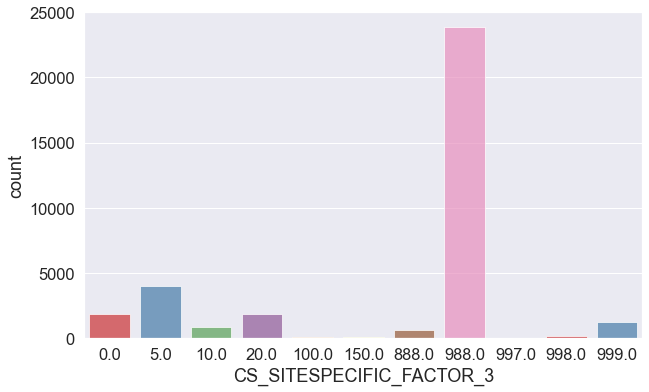

6736


In [54]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="CS_SITESPECIFIC_FACTOR_3", data=mcc_ncdb, palette="Set1", alpha=.7)
plt.show()
print(len(mcc_ncdb[mcc_ncdb['CS_SITESPECIFIC_FACTOR_3'] < 20]))

label > 100 = Not available

In [56]:
# only keep those that are coded 000, 005 and 010
mcc_ncdb_new = mcc_ncdb[mcc_ncdb['CS_SITESPECIFIC_FACTOR_3'] < 20].replace([0.0,5.0,10.0],[0,0,1])
mcc_ncdb_new.drop(['PUF_CASE_ID','PUF_FACILITY_ID',
                   'FACILITY_TYPE_CD','FACILITY_LOCATION_CD'
                  ], axis=1, inplace=True)

In [57]:
mcc_ncdb_new.head()

,AGE,SEX,RACE,SPANISH_HISPANIC_ORIGIN,INSURANCE_STATUS,MED_INC_QUAR_00,NO_HSD_QUAR_00,UR_CD_03,MED_INC_QUAR_12,NO_HSD_QUAR_12,...,RX_HOSP_SURG_PRIM_SITE,RX_HOSP_CHEMO,RX_HOSP_IMMUNOTHERAPY,RX_HOSP_HORMONE,RX_HOSP_OTHER,PUF_MULT_SOURCE,PUF_REFERENCE_DATE_FLAG,RX_SUMM_SCOPE_REG_LN_2012,RX_HOSP_DXSTG_PROC,PALLIATIVE_CARE_HOSP
3,82,1,1,0,3,4.0,4.0,1.0,4.0,4.0,...,45,0,0,0,0,0,1,NaN,0,0
8,71,1,1,0,1,3.0,2.0,6.0,2.0,2.0,...,27,0,0,0,0,0,1,NaN,0,0
9,49,2,1,0,1,4.0,4.0,3.0,4.0,4.0,...,35,0,0,0,0,0,1,0.0,2,0
14,43,1,1,0,1,4.0,4.0,1.0,4.0,4.0,...,0,0,0,0,0,1,1,2.0,0,0
19,59,2,1,0,1,4.0,3.0,1.0,4.0,2.0,...,0,0,0,0,0,1,1,4.0,0,0


In [64]:
# create a list of 
mcc_ncdb_new.apply(lambda x: print(x.name,' ',x.dtype))

AGE   int64
SEX   int64
RACE   int64
SPANISH_HISPANIC_ORIGIN   int64
INSURANCE_STATUS   int64
MED_INC_QUAR_00   float64
NO_HSD_QUAR_00   float64
UR_CD_03   float64
MED_INC_QUAR_12   float64
NO_HSD_QUAR_12   float64
UR_CD_13   float64
CROWFLY   float64
CDCC_TOTAL_BEST   int64
SEQUENCE_NUMBER   int64
CLASS_OF_CASE   int64
YEAR_OF_DIAGNOSIS   int64
PRIMARY_SITE   object
LATERALITY   int64
HISTOLOGY   int64
BEHAVIOR   int64
GRADE   int64
DIAGNOSTIC_CONFIRMATION   int64
TUMOR_SIZE   int64
REGIONAL_NODES_POSITIVE   int64
REGIONAL_NODES_EXAMINED   int64
DX_STAGING_PROC_DAYS   float64
RX_SUMM_DXSTG_PROC   int64
TNM_CLIN_T   object
TNM_CLIN_N   object
TNM_CLIN_M   object
TNM_CLIN_STAGE_GROUP   object
TNM_PATH_T   object
TNM_PATH_N   object
TNM_PATH_M   object
TNM_PATH_STAGE_GROUP   object
TNM_EDITION_NUMBER   int64
ANALYTIC_STAGE_GROUP   int64
CS_METS_AT_DX   int64
CS_METS_EVAL   int64
CS_EXTENSION   int64
CS_TUMOR_SIZEEXT_EVAL   int64
CS_METS_DX_BONE   float64
CS_METS_DX_BRAIN   float64
CS_MET

AGE                          None
SEX                          None
RACE                         None
SPANISH_HISPANIC_ORIGIN      None
INSURANCE_STATUS             None
                             ... 
PUF_MULT_SOURCE              None
PUF_REFERENCE_DATE_FLAG      None
RX_SUMM_SCOPE_REG_LN_2012    None
RX_HOSP_DXSTG_PROC           None
PALLIATIVE_CARE_HOSP         None
Length: 122, dtype: object

## First remove those with zero variance (all have same value)

Goal is to have less features for EDA

In [58]:
zv_sel = VarianceThreshold(threshold=0)
mcc_ncdb_new = zv_sel.fit_transform(mcc_ncdb_new)

ValueError: could not convert string to float: 'C441'

## Distribution (check missing values)

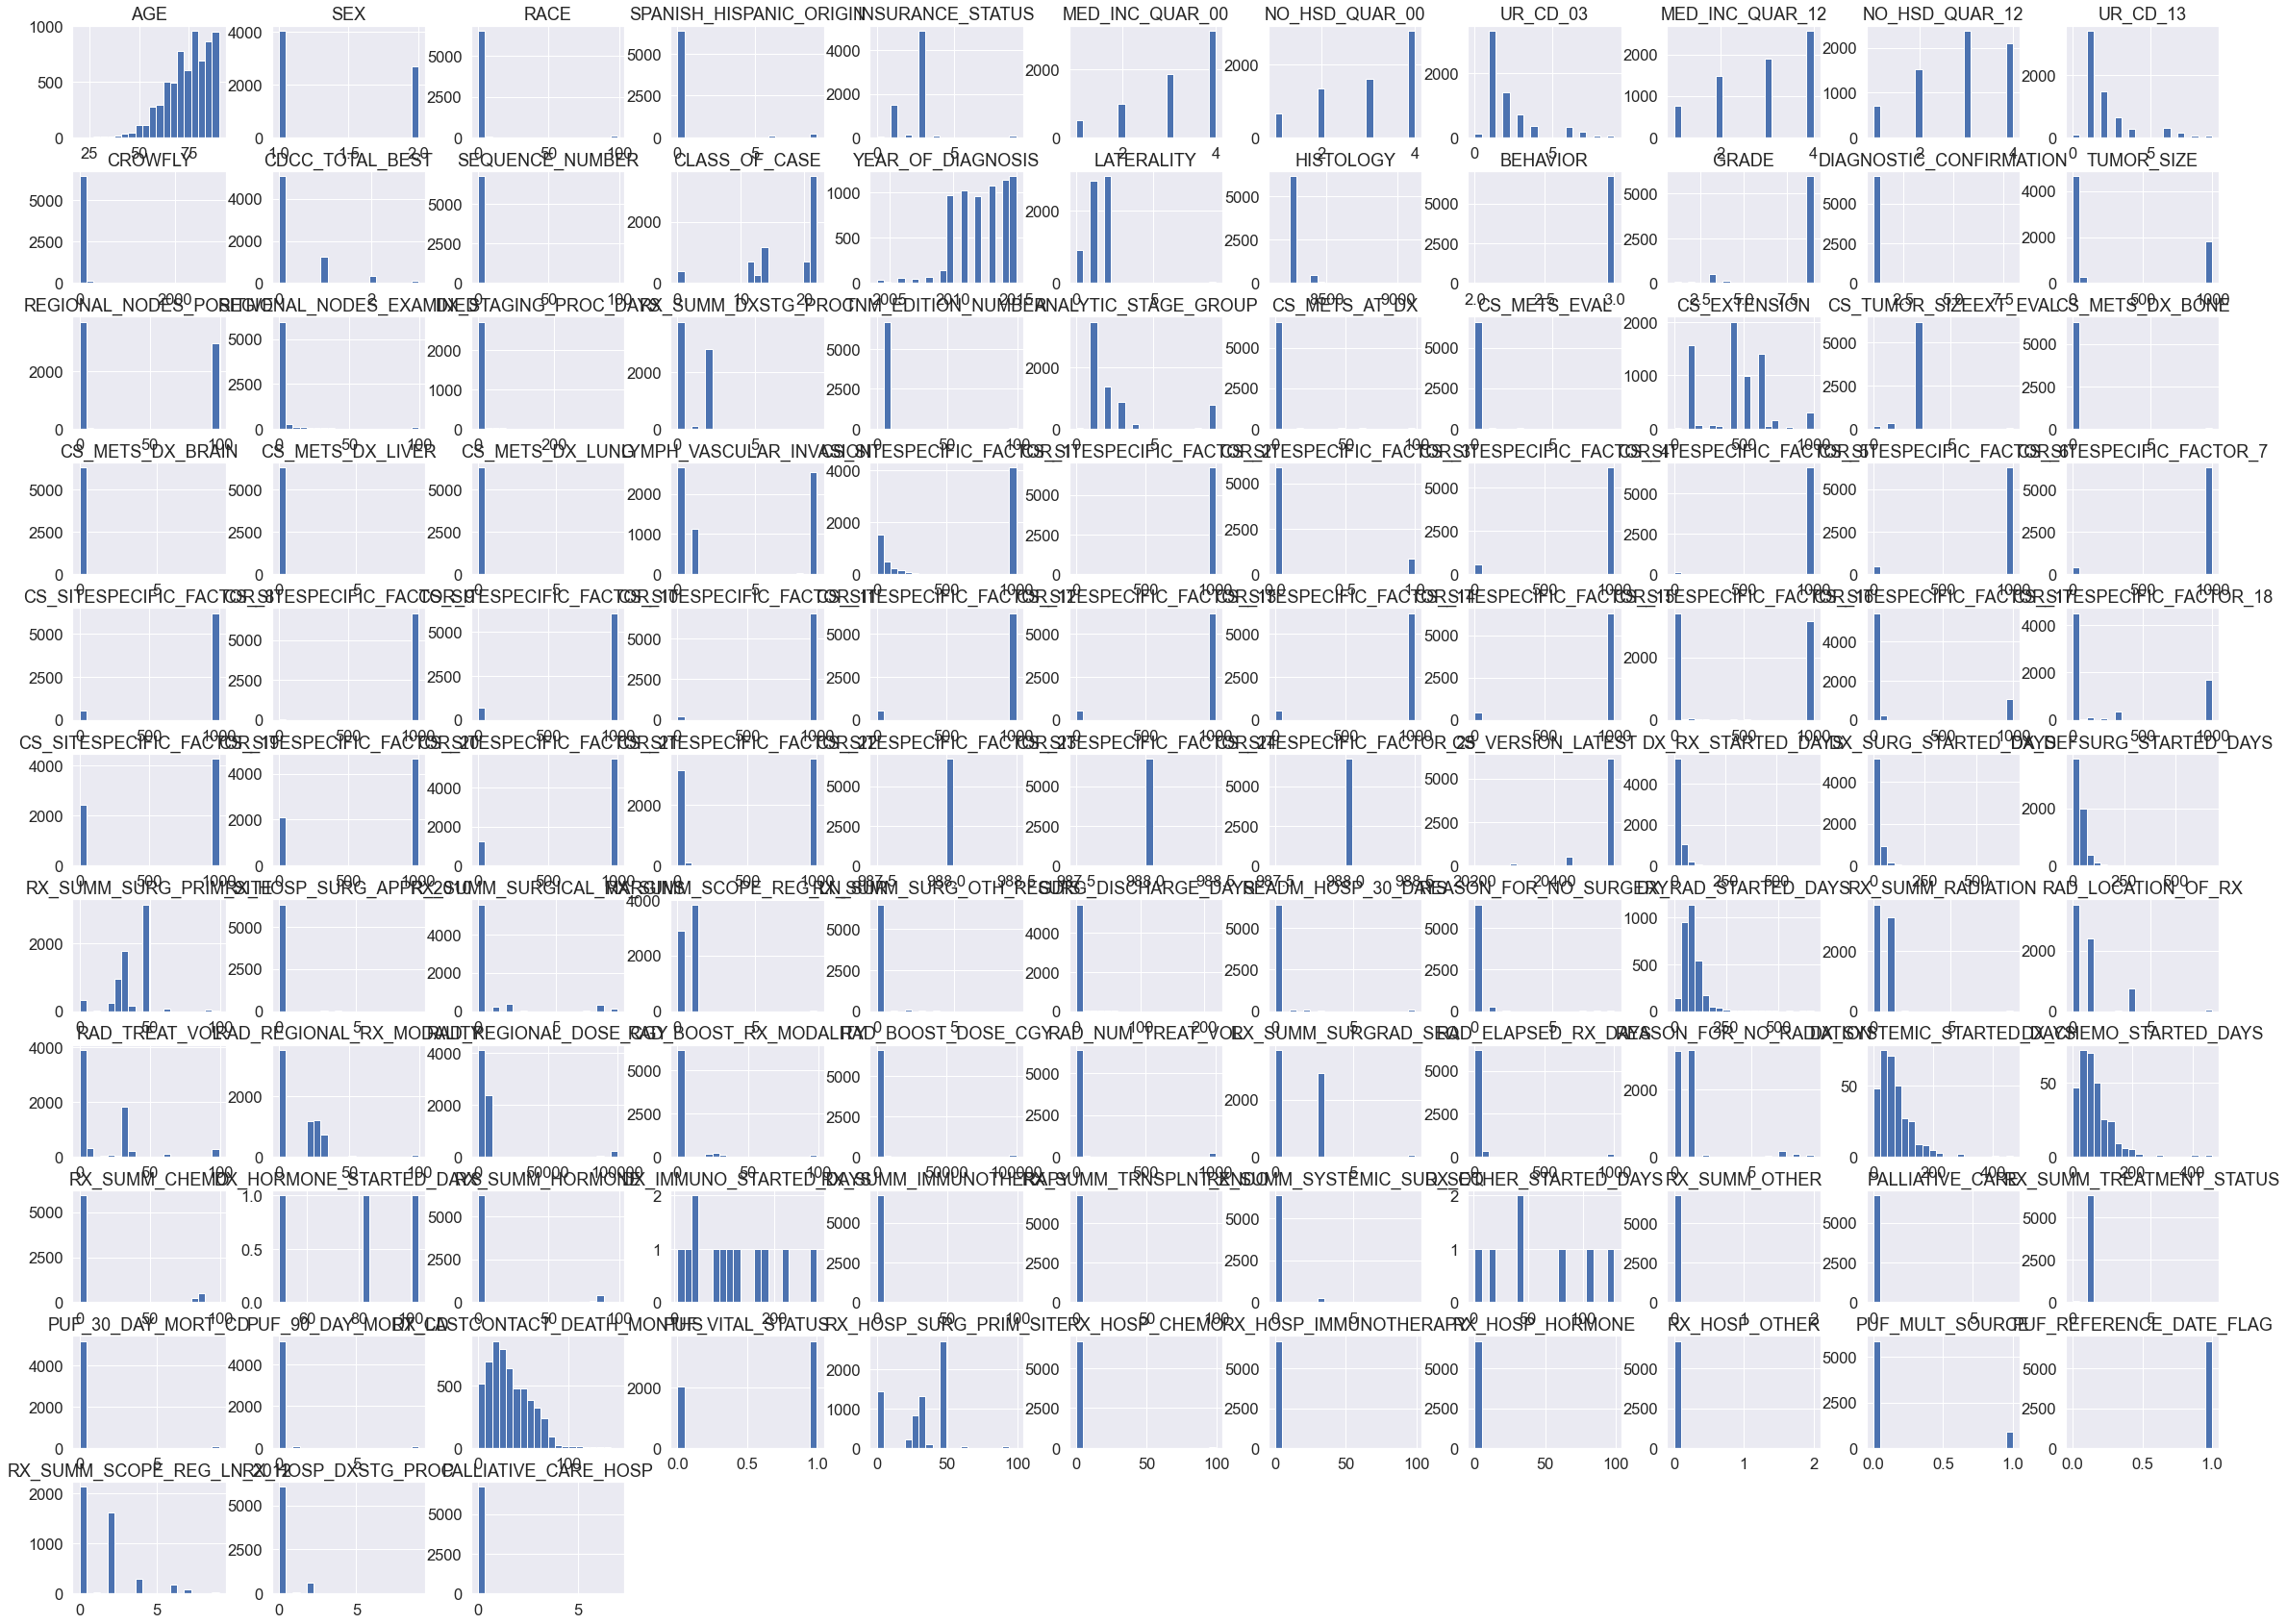

In [52]:
mcc_ncdb_new.drop(['PUF_CASE_ID','PUF_FACILITY_ID',
                   'FACILITY_TYPE_CD','FACILITY_LOCATION_CD'
                  ], axis=1).hist(bins=20, figsize=(40,30))
plt.rcParams.update({'font.size': 28, })
plt.show()

## Ideas to note:

- CoxPH
- LASSO-Cox
- Random Survival Forest